In [1]:
print(5+2)

In [2]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as LSCm
from scipy.interpolate import griddata
from scipy.signal import savgol_filter
from scipy import integrate


In [3]:
from NesrHydrusAnalyst import *

In [4]:
def draw_full_contour(data_frame,variable=0, time_step=180, grid= 0.5, 
                      crosses=35., tol=10., section= 'x', levels=None,
                      plot_title="ElNesr cross sectional contour map",
                      return_arrays=True, x_step=None, z_step=None,
                      mirror_x=False, mirror_z=False, is2d=False, 
                      output_the_contour=True, is_axisymmetric=False,
                      return_figure_object=False):
    
    '''
    Either (1) set the return_arrays to True and use on right 
                hand side of equal sign, 
    OR     (2) set the return_arrays to False and use the function as is.
    Examples:
    (1)
       arrays = draw_full_contour(data_frame,variable, time_step, grid, 
                                   crosses, tol, section)
       It will draws the chart AND sets arrays=X, Z, M, levels
    (2)
       draw_full_contour(data_frame,variable, time_step, grid, crosses, 
                           tol, section, return_arrays=False)    
    '''
#     print('is2d=', is2d)
    X, Z, M, x_vals, z_vals = get_grid_values(data_frame, variable, 
                                              time_step, grid, crosses, 
                                              tol, section, is2d=is2d,
                                             is_axisymmetric=is_axisymmetric)
    # print(x_vals.shape, z_vals.shape, X.shape, Z.shape, M.shape)
    if levels is None:
        levels = get_legend_range(np.nanmin(M),np.nanmax(M))#np.arange(0.15, 0.42, 0.03)

    mn, mx = np.nanmin(M),np.nanmax(M)
    # print (mx,mn, mx-mn)
    if mx - mn < 0.000000001:
        print('For the requested contour map of {}'.format(plot_title), end='. ')
        print ("The map has one value only ({}), no contour map will be drawn.".
               format(mn))
        can_draw_figure=False
    else:
        can_draw_figure=True

    if not output_the_contour and not return_figure_object:
        fig = None
    else:
        if can_draw_figure:
            fig = draw_contour(X, Z, M, levels, plot_title, x_step, z_step,
                             mirror_x, mirror_z, return_figure_object);
        else:
            fig = None

#     exit()
    if return_arrays:
        if output_the_contour:
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
                return X, Z, M, levels
        else:  #output_the_contour=False
            if return_figure_object:
                return X, Z, M, levels, fig
            else: # return_figure_object=False
                return X, Z, M, levels
    else:  #return_arrays=False
        if output_the_contour:
            if return_figure_object:
                return fig
            else: # return_figure_object=False
                display(fig)
                # fig.show()
        else:  #output_the_contour=False
            if return_figure_object:
                return fig

In [15]:
def draw_contour(X, Z, M, levels=None, 
                 plot_title="ElNesr cross sectional contour map",
                x_step=10., z_step=25., mirror_x=False, mirror_z=False,
                return_figure_object=False):
    '''
    
    '''
#     print('mir_X draw_contour: ', mirror_x)
    fig = plt.figure(num=None, figsize=(18, 7), dpi=80, facecolor='w', edgecolor='k');
    origin = 'lower'
    
    if levels is None:
#         print(M.min(), M.max())
        try:
#             levels = get_legend_range(M.min(), M.max())#np.arange(0.15, 0.42, 0.03)
            levels = get_legend_range(np.nanmin(M),np.nanmax(M))#np.arange(0.15, 0.42, 0.03)
        except:
            levels = get_legend_range(-.15, 0.15)
        
#     CS_lines = plt.contour (X, Z, M, levels, cmap=plt.cm.Accent_r,
#                             linewidths=(2,), origin=origin, extend='both')
#     CS_lines = plt.contour (X, Z, M, levels, cmap=plt.cm.Accent_r,
#                             linewidths=(0.25,), origin=origin, extend='both')
    CS_lines = plt.contour (X, Z, M, levels, cmap=plt.cm.Accent_r,
                            linewidths=(0.25,), origin=origin, extend='both')
    
    CS_fill  = plt.contourf(X, Z, M, levels, cmap=plt.cm.YlGn, 
                            origin=origin, extend='both')
    
    CS_fill.cmap.set_under('oldlace')
    CS_fill.cmap.set_over('darkslategrey')
    plt.title(plot_title)
    plt.ylabel("Depth (cm)")
    cols = plt.cm.Accent_r(CS_lines.norm(CS_lines.levels))
    #plt.clabel(CS_lines, linewidths=4, fmt='%2.2f', fontsize='x-large', 
    plt.clabel(CS_lines, fmt='%2.2f', fontsize='x-large', 
               colors=cols, inline=True, inline_spacing=10)
    plt.colorbar(CS_fill)
#     print(Z.min(), Z.max(), X.min(), X.max())
#     print(plt.xlim)

    def adjust_max_and_min(_min, _max, _step):
        nn, xx, ss = _min, _max, _step
        if xx <= 0.:
            nn, xx = xx, nn
            if ss>0:
                ss = -ss
        return nn,xx, ss
        
    def adjust_axis_labels(_min, _max, _step):
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)

        x_list = np.arange(nn,xx, ss)
        if abs(x_list[-1]-xx)>3: # The last number is far enough from 
                                 # the maximum element
            x_list = np.hstack([x_list, xx])
        else:  # The last number is too close to the maximum element
            x_list = np.hstack([x_list[:-1], xx])
        return x_list

    def adjust_mirrored_labels(_min, _max, _step):
#         print(_min, _max, _step)
        nn, xx, ss = adjust_max_and_min(_min, _max, _step)
#         print(nn, xx, ss)
        x_mid=(xx-nn)/2.
#         print(x_mid)
        
        if x_mid < 0:
            right_list = adjust_axis_labels(min(x_mid, xx), max(x_mid, xx), ss)
#             print('Right list',right_list)
            left_list = right_list - x_mid
#             print('left List',left_list)
            right_list = x_mid - right_list 
#             print('Right list2',right_list)
            
            left_list.sort()
#             print('left List2', left_list)

            label_list = np.hstack([left_list[:-1], right_list])
#             print('Label list',label_list)
            
            real_list =x_mid-label_list 
#             print('Real list',real_list)
            label_list=label_list[::-1]
#             print('Label list3',label_list)
            return real_list, label_list
        elif x_mid > 0:
            right_list = adjust_axis_labels(x_mid, xx, ss)
#             print('Right list',right_list)
            left_list = 2 * x_mid - right_list
#             print(left_list)
            left_list.sort()
#             print(left_list)
            real_list = np.hstack([left_list[:-1], right_list])
#             print(real_list)
            label_list =real_list - x_mid
#             print(label_list)
            label_list =tuple(['{:3.1f}'.format(x) for x in label_list])
#             print(label_list)
            return real_list, label_list
        else:
            real_list, label_list = None, None
            return real_list, label_list
            
        
        
#     print('mir_X draw_contour2: ', mirror_x, 'x_step: ', x_step)
    if mirror_x:
        if x_step is not None:
            ticks, labels = adjust_mirrored_labels(X.min(),X.max(), x_step)
#             print(ticks, labels)
            plt.xticks(ticks, labels)
    else: # No Mirroring
        if x_step is not None:
            plt.xticks(adjust_axis_labels(X.min(),X.max(), x_step))

    if mirror_z:
        if z_step is not None:
            ticks, labels = adjust_mirrored_labels(Z.min(),Z.max(), z_step)
            plt.yticks(ticks, labels)
    else: # No Mirroring
        if z_step is not None:
            plt.yticks(adjust_axis_labels(Z.min(),Z.max(), z_step))
#     ax=plt.axes()
    ax = plt.gca()
    ax.grid(True, zorder=0)
#     plt.axes().xaxis.grid(True, zorder=0)
#     plt.axes().yaxis.grid(True, zorder=0)
    # plt.colorbar(CS_lines)
    if return_figure_object:
        return fig
    else:
        plt.show()

In [5]:
src = '../Datasets/sample3d'

In [6]:
# tests get_grid_values
data_frame= read_hydrus_data(folder=src, save_to_csv=False)
v=0
X, Z, M, x_vals, z_vals = get_grid_values(data_frame,variable=v)
print('x_vals{}, z_vals{}, X{}, Z{}, M{}'.format(x_vals.shape, 
                                                 z_vals.shape, X.shape, 
                                                 Z.shape, M.shape))

x_vals(201,), z_vals(251,), X(251, 201), Z(251, 201), M(251, 201)


In [7]:
get_available_timesteps(data_frame)

[0, 15, 60, 120, 180, 360, 720, 1440]

In [8]:
get_full_dimensions(data_frame)

{'x': (0.0, 70.0), 'y': (0.0, 100.0), 'z': (-125.0, 0.0)}

In [9]:
get_legend_range(M.min(), M.max())

array([0.230, 0.240, 0.250, 0.260, 0.270, 0.280, 0.290, 0.300, 0.310,
       0.320, 0.330, 0.340, 0.350])

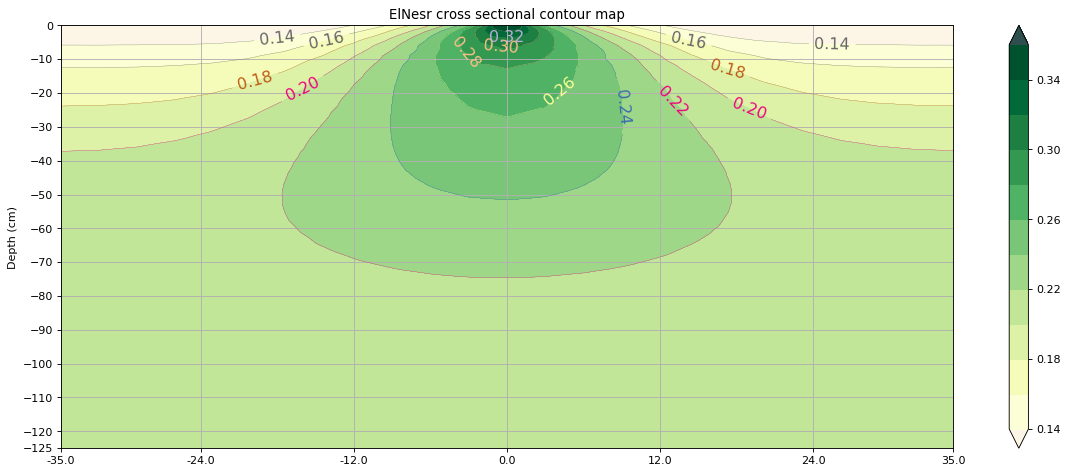

None

In [18]:
# testing draw_full_contour function
# data_frame_test = read_hydrus_data(save_to_csv=False)
variable   = 0 # Theta
time_step  = 180
grid       = 0.5 # cm
crosses    = 35.  #cm0)]
tol        = 10.
section    ='y'

# Either (1) set the return_arrays to True and use on right hand side of equal sign, 
# OR     (2) set the return_arrays to False and use the function as is.

# (1)
# arrays = draw_full_contour(data_frame_test,variable, time_step, 
#                            grid, crosses, tol, section)
# (2)
# draw_full_contour(data_frame_test,variable, time_step, 
draw_full_contour(data_frame,variable, time_step, 
                  grid, crosses, tol, section, 
                  return_arrays=False, 
                  x_step=12, z_step=10, 
                  mirror_x=True, mirror_z=False)